<a href="https://colab.research.google.com/github/Ciciliaparastita/Portofolio/blob/main/Mentoring_4_Fraud_Analytics_Cicilia_Parastita_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1st CASE

##Q1

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score

# Load the dataset
df = pd.read_csv("transaction_sample.csv")

# Copy the data to avoid modifying the original
df_prediction_confidence = df.copy()

# Calculate prediction confidence score (absolute distance from 0.5)
df_prediction_confidence["prediction_confidence"] = np.abs(0.5 - df_prediction_confidence["y_pred_proba"])

# Select the top-k most uncertain samples (highest prediction_confidence)
k = 100  # Adjust based on expert capacity
top_k_uncertain = df_prediction_confidence.nsmallest(k, "prediction_confidence")

# Final output: Columns to be reviewed by experts
columns_for_expert = [
    "Transaction ID", "Transaction Amount", "Account Age Days",
    "Transaction Hour", "y_pred", "y_pred_proba"
]
expert_review_set = top_k_uncertain[columns_for_expert]

# Display the samples for expert labeling
print(expert_review_set)


                            Transaction ID  Transaction Amount  \
3109  257cd22f-3067-459f-9cd8-cf9efcc9c37f              506.98   
4665  53c3d2ce-55d9-4292-be77-b62982f0121f              162.21   
3454  01087804-0734-4813-89a7-72c4d0b6cd34              110.95   
2534  49dd2520-9cb9-43f9-b2d9-4056b07dd124             1003.75   
1113  23a20489-817b-4fbb-84e1-157f3012c238               70.53   
...                                    ...                 ...   
3574  b13c42aa-f7b3-4f3a-a054-ba244ca40bc7              191.40   
3777  aabb3c04-64ae-46aa-99c9-3edad34fe2fc              499.35   
288   ac9cae4a-176f-4af0-a16d-edff39eca5b0               39.09   
2351  35a4b95d-8032-4ff6-be38-ea2c5f919d65              427.30   
2915  8e121eee-a7bc-4b08-82bb-36ec518d55dd               68.74   

      Account Age Days  Transaction Hour  y_pred  y_pred_proba  
3109                22                 5       1      0.500594  
4665                38                 7       1      0.503446  
3454        

##Q2

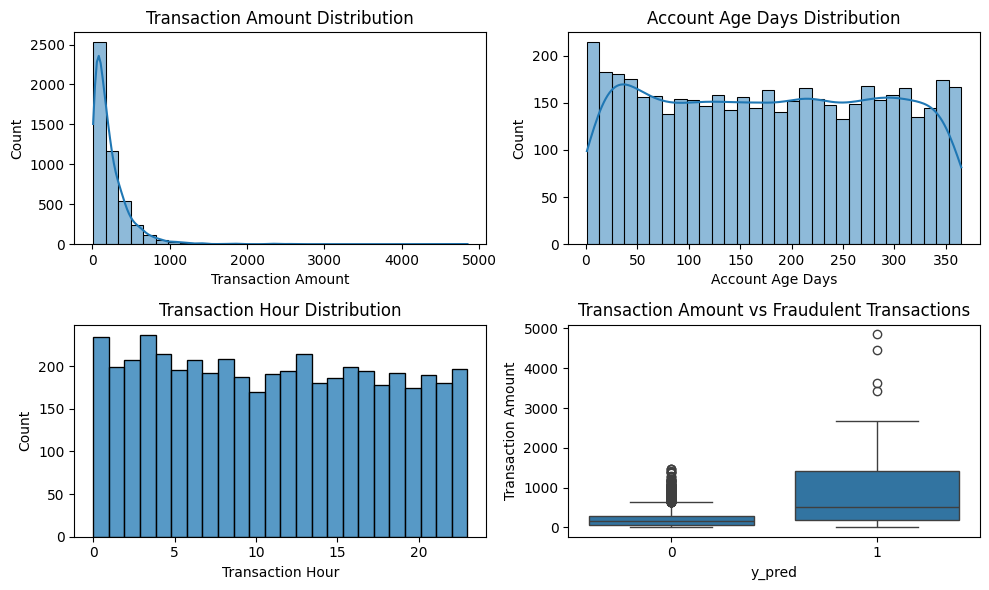

In [35]:
# EDA to understand patterns
plt.figure(figsize=(10, 6))

# Transaction Amount distribution
plt.subplot(2, 2, 1)
sns.histplot(df['Transaction Amount'], kde=True, bins=30)
plt.title('Transaction Amount Distribution')

# Account Age distribution
plt.subplot(2, 2, 2)
sns.histplot(df['Account Age Days'], kde=True, bins=30)
plt.title('Account Age Days Distribution')

# Transaction Hour distribution
plt.subplot(2, 2, 3)
sns.histplot(df['Transaction Hour'], kde=False, bins=24)
plt.title('Transaction Hour Distribution')

# Correlation between features and fraud status
plt.subplot(2, 2, 4)
sns.boxplot(x='y_pred', y='Transaction Amount', data=df)
plt.title('Transaction Amount vs Fraudulent Transactions')

plt.tight_layout()
plt.show()

In [36]:
# Define expert annotation function based on EDA rules
def expert_annotation(row):
    # High transaction amount
    if row['Transaction Amount'] > 500:
        return 1  # Fraudulent
    # New accounts
    elif row['Account Age Days'] < 30:
        return 1  # Fraudulent
    # Late-night transactions
    elif 0 <= row['Transaction Hour'] <= 6:
        return 1  # Fraudulent
    else:
        return 0  # Legitimate

# Apply the expert annotation to the uncertain transactions
df_prediction_confidence['y_pred_exp'] = df_prediction_confidence.apply(expert_annotation, axis=1)

# Compare the original model predictions with the expert annotations
y_true = df_prediction_confidence['y_pred']  # Assuming we have ground truth (actual fraud labels)
y_pred = df_prediction_confidence['y_pred_exp']

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(y_true, y_pred)
print("Classification Report:\n", class_report)


Confusion Matrix:
 [[2642 2004]
 [   1   80]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.57      0.72      4646
           1       0.04      0.99      0.07        81

    accuracy                           0.58      4727
   macro avg       0.52      0.78      0.40      4727
weighted avg       0.98      0.58      0.71      4727



##Q3

###ROC-AUC Evaluation

In [37]:
# Before HITL: Using y_pred (ML model's original prediction)
roc_auc_before_hitl = roc_auc_score(y_true, df_prediction_confidence['y_pred_proba'])

# After HITL: Using y_pred_exp (model after incorporating expert annotations)
roc_auc_after_hitl = roc_auc_score(y_true, df_prediction_confidence['y_pred_exp'])

print(f"ROC AUC Before HITL: {roc_auc_before_hitl}")
print(f"ROC AUC After HITL: {roc_auc_after_hitl}")


ROC AUC Before HITL: 1.0
ROC AUC After HITL: 0.778157767467568


### False Prediction Cost Calculation

In [38]:
# Assuming 'Is Fraudulent' is the ground truth column (y_true)
df_prediction_confidence['y_true'] = df_prediction_confidence['Is Fraudulent']

# Filter the False Positives and False Negatives
fp_before_hitl = df_prediction_confidence[(df_prediction_confidence['y_pred'] == 1) & (df_prediction_confidence['y_true'] == 0)]
fn_before_hitl = df_prediction_confidence[(df_prediction_confidence['y_pred'] == 0) & (df_prediction_confidence['y_true'] == 1)]

fp_after_hitl = df_prediction_confidence[(df_prediction_confidence['y_pred_exp'] == 1) & (df_prediction_confidence['y_true'] == 0)]
fn_after_hitl = df_prediction_confidence[(df_prediction_confidence['y_pred_exp'] == 0) & (df_prediction_confidence['y_true'] == 1)]

# Calculate the total cost for FP and FN
fp_cost_before_hitl = fp_before_hitl['Transaction Amount'].sum()
fn_cost_before_hitl = fn_before_hitl['Transaction Amount'].sum()

fp_cost_after_hitl = fp_after_hitl['Transaction Amount'].sum()
fn_cost_after_hitl = fn_after_hitl['Transaction Amount'].sum()

print(f"FP Cost Before HITL: {fp_cost_before_hitl}")
print(f"FN Cost Before HITL: {fn_cost_before_hitl}")
print(f"FP Cost After HITL: {fp_cost_after_hitl}")
print(f"FN Cost After HITL: {fn_cost_after_hitl}")


FP Cost Before HITL: 11939.789999999999
FN Cost Before HITL: 66660.13
FP Cost After HITL: 516982.27999999997
FN Cost After HITL: 4894.48


### Execution Time Cost Calculation

In [39]:
# Define number of transactions in the dataset
num_transactions = len(df_prediction_confidence)

# Model processing time per transaction (in seconds)
model_processing_time = 0.00012

# Expert review time per transaction (in seconds)
expert_review_time = 5

# Total time calculation
time_before_hitl = num_transactions * model_processing_time
time_after_hitl = num_transactions * (model_processing_time + expert_review_time)

# Calculate the execution time cost
execution_time_cost_before_hitl = time_before_hitl * 0.01  # $0.01 per second
execution_time_cost_after_hitl = time_after_hitl * 0.01  # $0.01 per second

print(f"Execution Time Cost Before HITL: ${execution_time_cost_before_hitl:.2f}")
print(f"Execution Time Cost After HITL: ${execution_time_cost_after_hitl:.2f}")


Execution Time Cost Before HITL: $0.01
Execution Time Cost After HITL: $236.36


### Total Cost Calculation

In [40]:
# Total cost calculation
total_cost_before_hitl = fp_cost_before_hitl + fn_cost_before_hitl + execution_time_cost_before_hitl
total_cost_after_hitl = fp_cost_after_hitl + fn_cost_after_hitl + execution_time_cost_after_hitl

print(f"Total Cost Before HITL: ${total_cost_before_hitl:.2f}")
print(f"Total Cost After HITL: ${total_cost_after_hitl:.2f}")


Total Cost Before HITL: $78599.93
Total Cost After HITL: $522113.12


**Model Performance:**
Before HITL (Human-in-the-Loop): The model achieved a perfect ROC AUC of 1.0, indicating flawless fraud detection with no misclassifications.

After HITL: The ROC AUC dropped to 0.78, suggesting a significant decrease in performance after incorporating expert annotations.

**Cost Analysis:**
Before HITL: The cost of false positives (FP) was $11,939.79, and false negatives (FN) was $66,660.13.

After HITL: The FP cost increase to $516,982.28, while FN cost dropped to $4,894.48. The large increase in false positive indicates that expert annotations may have introduced more errors than they resolved.

**Execution Time Cost:**
Before HITL: The execution time cost was negligible ($0.01).

After HITL: The execution time cost surged to $236.36, mainly due to the time required for expert review (5 seconds per transaction).

**Total Cost Comparison:**
Before HITL: Total cost was $78,599.93.

After HITL: Total cost ballooned to $522,113.12 due to increased false positive costs and human annotation time.

#2nd CASE

##Q1

In [41]:
import pandas as pd
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier



# Load the dataset
df = pd.read_csv('bank_data.csv')

# Check the first few rows of the dataset
df.head()

,step,customer,age,gender,merchant,category,amount,fraud
0,86,C1372889664,5,F,M1823072687,es_transportation,3.13,0
1,26,C377075708,2,M,M348934600,es_transportation,27.11,0
2,39,C1871594117,1,M,M1823072687,es_transportation,27.32,0
3,176,C730142143,4,F,M348934600,es_transportation,37.87,0
4,155,C1385354747,4,M,M1823072687,es_transportation,32.33,0


In [42]:
# Create a bipartite graph
B = nx.Graph()

# Add customer and merchant nodes
B.add_nodes_from(df['customer'], bipartite=0)  # Customer nodes
B.add_nodes_from(df['merchant'], bipartite=1)  # Merchant nodes

# Add edges based on transactions, with fraud status as edge attribute
for index, row in df.iterrows():
    B.add_edge(row['customer'], row['merchant'], fraud=row['fraud'])

# Check the graph details
B.nodes(), B.edges(data=True)

(NodeView(('C1372889664', 'C377075708', 'C1871594117', 'C730142143', 'C1385354747', 'C1799882713', 'C2116616608', 'C407936671', 'C877773949', 'C1793075309', 'C1580753738', 'C1354799046', 'C1049562739', 'C1619755203', 'C956954767', 'C206074131', 'C116386695', 'C717345438', 'C1739071229', 'C1457388461', 'C1928637369', 'C1394454342', 'C1130847219', 'C1035666255', 'C471166875', 'C824784700', 'C720418898', 'C251449240', 'C1992960127', 'C464042268', 'C177123752', 'C2030210340', 'C1667002698', 'C1950870438', 'C351144071', 'C1587738251', 'C846682077', 'C398651508', 'C114981535', 'C1178005728', 'C98014803', 'C759940472', 'C525158878', 'C995235283', 'C1248053373', 'C1028995887', 'C1005495267', 'C1199849921', 'C17589297', 'C1591008232', 'C2143703121', 'C378899672', 'C1029994689', 'C949319027', 'C647931416', 'C1873506157', 'C469767739', 'C5079947', 'C320158645', 'C864725258', 'C1887082660', 'C1160118068', 'C447271561', 'C298317613', 'C1783773775', 'C1132392725', 'C1553941793', 'C1700873233', 'C148

In [43]:
# Calculate the number of fraudulent transactions for each customer
fraudulent_customers = {}
for customer in B.nodes():
    # Count edges where the fraud attribute is 1 (fraudulent transaction)
    fraudulent_transactions = sum(1 for _, _, data in B.edges(customer, data=True) if data['fraud'] == 1)
    fraudulent_customers[customer] = fraudulent_transactions

# Sort the customers by fraudulent transactions and get the top three
sorted_fraudulent_customers = sorted(fraudulent_customers.items(), key=lambda x: x[1], reverse=True)[:3]
sorted_fraudulent_customers

[('M480139044', 45), ('M980657600', 41), ('M732195782', 19)]

In [44]:
# Filter customers with only fraudulent transactions
fraudulent_customers_only = df[df['fraud'] == 1].groupby('customer').filter(lambda x: len(x) == len(x[x['fraud'] == 1]))

# Identify merchants that are most frequently connected to fraudulent customers
fraudulent_merchants = fraudulent_customers_only['merchant'].value_counts().head(3)
fraudulent_merchants

,count
merchant,
M480139044,49
M980657600,48
M732195782,20


In [45]:
# List customers whose all transactions are fraudulent
fraudulent_customers_all = df.groupby('customer').filter(lambda x: all(x['fraud'] == 1))

# List merchants whose all transactions are fraudulent
fraudulent_merchants_all = df.groupby('merchant').filter(lambda x: all(x['fraud'] == 1))

fraudulent_customers_all[['customer']], fraudulent_merchants_all[['merchant']]

(          customer
 430     C431496464
 822    C1728122351
 996    C1562081159
 1201   C2113737065
 1235    C644541754
 1636   C2004941826
 2017    C617723960
 2041   C1728122351
 2505    C903333805
 2889    C910454738
 3118    C483912131
 3586    C932908444
 3620    C204205576
 3733   C2126657609
 3802    C617723960
 3893   C2004941826
 4003   C1817318774
 4490    C932908444
 4500   C2078688167
 4503   C1560904250
 5076   C1728122351
 6513    C644541754
 7218   C1747786179
 7354    C617723960
 7622    C751887992
 8329    C910454738
 8396   C1233811793
 8487   C1803182614
 8798    C644541754
 8833   C2113737065
 9023    C483912131
 9670   C2004941826
 10001  C2060410910
 10196   C932908444
 10269  C1685492470
 10754  C1289997724
 10957  C1685492470
 11716   C150891114
 11738  C1685492470
 11850   C204205576
 12178   C483912131
 12331  C1572610482
 14005  C1572610482
 14989   C211657450
 15132  C1903013338
 15437  C1501096176
 16102  C2138532527
 16579    C60324613
 16625  C1572610482


##Q2

In [46]:
# Create a bipartite graph (same as before)
B = nx.Graph()

# Add nodes (customers and merchants)
B.add_nodes_from(df['customer'], bipartite=0)  # Customer nodes
B.add_nodes_from(df['merchant'], bipartite=1)  # Merchant nodes

# Add edges with fraud as an attribute
for index, row in df.iterrows():
    B.add_edge(row['customer'], row['merchant'], fraud=row['fraud'], amount=row['amount'])

# Check the graph details
B.nodes(), B.edges(data=True)

(NodeView(('C1372889664', 'C377075708', 'C1871594117', 'C730142143', 'C1385354747', 'C1799882713', 'C2116616608', 'C407936671', 'C877773949', 'C1793075309', 'C1580753738', 'C1354799046', 'C1049562739', 'C1619755203', 'C956954767', 'C206074131', 'C116386695', 'C717345438', 'C1739071229', 'C1457388461', 'C1928637369', 'C1394454342', 'C1130847219', 'C1035666255', 'C471166875', 'C824784700', 'C720418898', 'C251449240', 'C1992960127', 'C464042268', 'C177123752', 'C2030210340', 'C1667002698', 'C1950870438', 'C351144071', 'C1587738251', 'C846682077', 'C398651508', 'C114981535', 'C1178005728', 'C98014803', 'C759940472', 'C525158878', 'C995235283', 'C1248053373', 'C1028995887', 'C1005495267', 'C1199849921', 'C17589297', 'C1591008232', 'C2143703121', 'C378899672', 'C1029994689', 'C949319027', 'C647931416', 'C1873506157', 'C469767739', 'C5079947', 'C320158645', 'C864725258', 'C1887082660', 'C1160118068', 'C447271561', 'C298317613', 'C1783773775', 'C1132392725', 'C1553941793', 'C1700873233', 'C148

In [47]:
# Degree centrality for customers and merchants
customer_degree_centrality = {node: B.degree(node) for node in df['customer'].unique()}
merchant_degree_centrality = {node: B.degree(node) for node in df['merchant'].unique()}

# Adding the degree centrality to the dataframe
df['customer_degree_centrality'] = df['customer'].map(customer_degree_centrality)
df['merchant_degree_centrality'] = df['merchant'].map(merchant_degree_centrality)

In [48]:
# Calculate fraud proximity score for customers
cust_fraud_counts = df.groupby('customer')['fraud'].sum()
cust_total_counts = df.groupby('customer')['fraud'].count()
df['cust_fraud_proxim_score'] = df['customer'].map(lambda x: cust_fraud_counts[x] / cust_total_counts[x] if cust_total_counts[x] > 0 else 0)

# Calculate fraud proximity score for merchants
merchant_fraud_counts = df.groupby('merchant')['fraud'].sum()
merchant_total_counts = df.groupby('merchant')['fraud'].count()
df['merchant_fraud_proxim_score'] = df['merchant'].map(lambda x: merchant_fraud_counts[x] / merchant_total_counts[x] if merchant_total_counts[x] > 0 else 0)

In [49]:
# Calculate average transaction amount for customers
cust_avg_amt = df.groupby('customer')['amount'].mean()
df['cust_avg_amt'] = df['customer'].map(cust_avg_amt)

# Calculate average transaction amount for merchants
merchant_avg_amt = df.groupby('merchant')['amount'].mean()
df['merchant_avg_amt'] = df['merchant'].map(merchant_avg_amt)

In [50]:
# Store the six features for model training
features_df = df[['customer', 'merchant', 'fraud', 'customer_degree_centrality',
                  'merchant_degree_centrality', 'cust_fraud_proxim_score',
                  'merchant_fraud_proxim_score', 'cust_avg_amt', 'merchant_avg_amt']]

# Check the first few rows of the features dataframe
features_df.head()

,customer,merchant,fraud,customer_degree_centrality,merchant_degree_centrality,cust_fraud_proxim_score,merchant_fraud_proxim_score,cust_avg_amt,merchant_avg_amt
0,C1372889664,M1823072687,0,2,3081,0.0,0.0,11.713333,27.124874
1,C377075708,M348934600,0,3,2747,0.0,0.0,41.082857,26.723216
2,C1871594117,M1823072687,0,2,3081,0.0,0.0,24.384000,27.124874
3,C730142143,M348934600,0,2,2747,0.0,0.0,36.246000,26.723216
4,C1385354747,M1823072687,0,2,3081,0.0,0.0,24.160000,27.124874


##Q3

In [51]:
# Select features for model training (excluding the fraud column as it's the target)
X = features_df[['customer_degree_centrality', 'merchant_degree_centrality',
                 'cust_fraud_proxim_score', 'merchant_fraud_proxim_score',
                 'cust_avg_amt', 'merchant_avg_amt']]
y = features_df['fraud']

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (important for Logistic Regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [52]:
# Train a Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Train the model using different values of C (regularization strength)
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred_log_reg = log_reg.predict_proba(X_test)[:, 1]  # Probability of class 1 (fraud)

# Evaluate using ROC-AUC
roc_auc_log_reg = roc_auc_score(y_test, y_pred_log_reg)
print(f'ROC-AUC for Logistic Regression: {roc_auc_log_reg:.4f}')


ROC-AUC for Logistic Regression: 0.9994


In [53]:
# Train a Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5)

# Fit the model
dt_model.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = dt_model.predict_proba(X_test)[:, 1]  # Probability of class 1 (fraud)

# Evaluate using ROC-AUC
roc_auc_dt = roc_auc_score(y_test, y_pred_dt)
print(f'ROC-AUC for Decision Tree: {roc_auc_dt:.4f}')


ROC-AUC for Decision Tree: 0.9631


In [54]:
# Compare the models
if roc_auc_log_reg > roc_auc_dt:
    print(f'Logistic Regression is the best model with ROC-AUC of {roc_auc_log_reg:.4f}')
else:
    print(f'Decision Tree is the best model with ROC-AUC of {roc_auc_dt:.4f}')


Logistic Regression is the best model with ROC-AUC of 0.9994


##Q4

In [55]:
print(features_df.columns)

Index(['customer', 'merchant', 'fraud', 'customer_degree_centrality',
       'merchant_degree_centrality', 'cust_fraud_proxim_score',
       'merchant_fraud_proxim_score', 'cust_avg_amt', 'merchant_avg_amt'],
      dtype='object')


In [56]:
# Extract features (excluding 'fraud' as it's the target)
X = features_df[['customer_degree_centrality', 'merchant_degree_centrality',
                 'cust_fraud_proxim_score', 'merchant_fraud_proxim_score',
                 'cust_avg_amt', 'merchant_avg_amt']]

# Target variable is 'fraud'
y = features_df['fraud']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [57]:
# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predict and evaluate using ROC-AUC
y_pred_log_reg = log_reg.predict_proba(X_test)[:, 1]
roc_auc_log_reg = roc_auc_score(y_test, y_pred_log_reg)
print(f'ROC-AUC for Logistic Regression: {roc_auc_log_reg:.4f}')


ROC-AUC for Logistic Regression: 0.9994


In [58]:
# Train Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5)
dt_model.fit(X_train, y_train)

# Predict and evaluate using ROC-AUC
y_pred_dt = dt_model.predict_proba(X_test)[:, 1]
roc_auc_dt = roc_auc_score(y_test, y_pred_dt)
print(f'ROC-AUC for Decision Tree: {roc_auc_dt:.4f}')


ROC-AUC for Decision Tree: 0.9631


In [59]:
# Summarize the ROC-AUC scores
evaluation_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree'],
    'ROC AUC': [roc_auc_log_reg, roc_auc_dt]
})

print(evaluation_comparison)


                 Model   ROC AUC
0  Logistic Regression  0.999389
1        Decision Tree  0.963100
